In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F  

from torch.utils.data import DataLoader, TensorDataset
import gymnasium 
import mon_env
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

In [2]:
# Parameters
sequence_length = 4  # Number of images in each sequence
num_episodes = 4000   # Number of episodes for data collection


# Environment Setup
env = gymnasium.make('MonCartPole-v1', render_mode = 'rgb_array')
data_images = []
data_states = []

# Transformer les images et les convertir en tenseurs
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((60, 135)),
    transforms.Grayscale()
])

In [3]:
# Cart location for centering image crop
def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

# Cropping, downsampling (and Grayscaling) image
def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render().transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    # Resize, and add a batch dimension (BCHW)
    return transform(screen.transpose(1,2,0)).squeeze(0)


In [4]:

# Collecter les données

for episode in range(num_episodes):
    observation = env.reset()[0] 
    images = [torch.zeros(60, 135) for _ in range(sequence_length)] # Initialisation avec images noires
    for t in range(1000):
        img = env.render()
        tensor_image = get_screen() # shape : 60x135
        # if t == 5:
        #     fig, axes = plt.subplots(1, 2, figsize=(15, 5))  
        #     axes[0].imshow(tensor_image)
        
        images.append(tensor_image)
        sequence_tensor = torch.stack(images[-sequence_length:], dim=0) # shape : 4 x 60 x 135 (si sequence_length = 4)
        data_images.append(sequence_tensor)
        data_states.append(observation)

        action = env.action_space.sample()  
        observation, reward, done, info, _ = env.step(action)
        if done:
            break

env.close()

# Convert data_states to a tensor 
data_states = torch.tensor(data_states, dtype=torch.float32)

# Dataset and DataLoader
dataset = TensorDataset(torch.stack(data_images), data_states)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

# Dans le dataloader : 
# images et labels associés. shape des images : 10 x 4 x 60 x 135
#                            shape des labels : 10 x 4 (10 = batch_size, 4 car (x,x_dot,theta,theta_dot))

c:\Users\titouan\anaconda3\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.x_threshold to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.x_threshold` for environment variables or `env.get_wrapper_attr('x_threshold')` that will search the reminding wrappers.
  logger.warn(
c:\Users\titouan\anaconda3\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.state to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.state` for environment variables or `env.get_wrapper_attr('state')` that will search the reminding wrappers.
  logger.warn(
C:\Users\titouan\AppData\Local\Temp\ipykernel_9668\1438530302.py:26: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at 

In [5]:
class CartPoleCNN(nn.Module):
    def __init__(self):
        super(CartPoleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(sequence_length, 16, kernel_size=5, stride=1, padding=2),  # Input: 4 gray images, output: 16 channels, 60x135
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # Output size: 30x67
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # Output size: 15x33
            # nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2)                  # Output size: 7x16
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(15840, 128),
            nn.ReLU(),
            nn.Linear(128,4)    # x, x_dot, theta, theta_dot
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layers
        x = self.fc_layers(x)
        return x

# Instanciation du modèle
model = CartPoleCNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

torch.Size([10, 4]) torch.Size([10, 4, 60, 135])
tensor([ 0.0369, -0.2094,  0.0320,  0.2687])


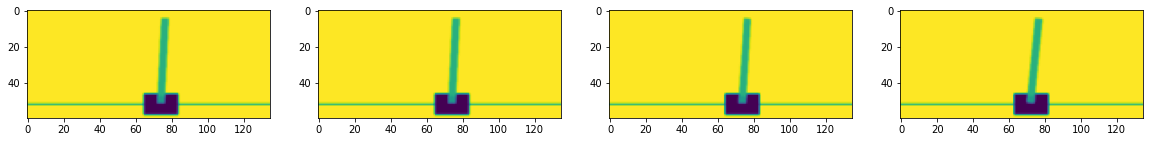

In [6]:
for images, labels in dataloader:
    print(labels.shape,images.shape) # (batch_size,4), (batch_size,sequence_length,60,135)
    fig,axes = plt.subplots(1,sequence_length,figsize = (20,30))
    for i in range(sequence_length):
        axes[i].imshow(images[0][i])
    print(labels[0])

    break

In [7]:
import time
# Training Loop
num_epochs = 40 # Peut-être avec plus d'epoch on obtiendrait un meilleur résultat ? jsp
# shoudl take about 12 hours :(
model.train()
for epoch in range(num_epochs):
    starttime = time.time()
    for images, states in dataloader:
        starttime = time.time()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, states)
        loss.backward()
        optimizer.step()
    endtime = time.time()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}, time: {endtime-starttime}')

Epoch 1, Loss: 0.026881594210863113, time: 0.09806489944458008
Epoch 2, Loss: 0.04815106466412544, time: 0.09857416152954102
Epoch 3, Loss: 0.03136144205927849, time: 0.09023237228393555
Epoch 4, Loss: 0.06454367935657501, time: 0.07785439491271973
Epoch 5, Loss: 0.03731458634138107, time: 0.12148833274841309
Epoch 6, Loss: 0.03273656219244003, time: 0.12516570091247559
Epoch 7, Loss: 0.02347732149064541, time: 0.08801412582397461
Epoch 8, Loss: 0.028955023735761642, time: 0.08293724060058594
Epoch 9, Loss: 0.0288323275744915, time: 0.08696961402893066
Epoch 10, Loss: 0.031219303607940674, time: 0.08836197853088379
Epoch 11, Loss: 0.028614094480872154, time: 0.08151459693908691
Epoch 12, Loss: 0.02447572723031044, time: 0.10570263862609863
Epoch 13, Loss: 0.032761044800281525, time: 0.09353804588317871
Epoch 14, Loss: 0.03336870297789574, time: 0.0966336727142334
Epoch 15, Loss: 0.034385472536087036, time: 0.09531807899475098
Epoch 16, Loss: 0.03197014331817627, time: 0.097157239913940

In [8]:
torch.save(model.state_dict(), 'big_dataset_model.pth')

In [9]:
model.eval()

for images, labels in dataloader:
    with torch.no_grad():
        print(model(images),labels)
    break



tensor([[-0.0881, -0.2590,  0.0972,  0.6359],
        [-0.0092, -0.0292, -0.0508, -0.0893],
        [-0.0058, -0.1997,  0.0267,  0.3673],
        [ 0.0515, -0.4126,  0.0539,  0.7681],
        [ 0.0194,  0.6104, -0.0678, -1.0007],
        [-0.1026, -0.6954,  0.1726,  1.4403],
        [ 0.0058, -0.3947,  0.0392,  0.6920],
        [ 0.0079, -0.0587,  0.0266,  0.0785],
        [ 0.0152, -0.0362,  0.0072,  0.1172],
        [-0.0662, -0.4603, -0.0057,  0.4803]]) tensor([[-0.0865, -0.3501,  0.0859,  0.7520],
        [-0.0227,  0.0160, -0.0768, -0.0807],
        [-0.0207, -0.4310,  0.0531,  0.8243],
        [ 0.0554, -0.3971,  0.0421,  0.7354],
        [ 0.0273,  0.6418, -0.0636, -1.0716],
        [-0.0899, -0.6364,  0.2065,  1.4455],
        [ 0.0148, -0.3859,  0.0327,  0.6212],
        [-0.0036, -0.2315,  0.0305,  0.2541],
        [ 0.0217, -0.1544, -0.0178,  0.3034],
        [-0.0793, -0.4319,  0.0175,  0.5101]])


In [10]:
# Voir encore mieux ce que ça donne

# 1 : On collecte des images du cartpole (heuristique : random)

env = gymnasium.make('CartPole-v1', render_mode = 'rgb_array')
data_images_bis = []
data_states_bis = []

for episode in range(3):
    observation_bis = env.reset()[0]
    images_bis = []
    for t in range(1000):
        img = env.render()
        tensor_image = transform(img).squeeze(0)  # Transform image immediately
        images_bis.append(tensor_image)
        
        if len(images_bis) >= sequence_length:
            # Stack the last sequence_length images to form a single sequence tensor
            sequence_tensor = torch.stack(images_bis[-sequence_length:], dim=0)
            data_images_bis.append(sequence_tensor)
            data_states_bis.append(observation)
        
        action = env.action_space.sample()   # Use the heuristic policy
        observation, reward, done, info, _ = env.step(action)
        if done:
            break
data_states_bis = torch.tensor(data_states_bis, dtype=torch.float32)

# Dataset and DataLoader
data_images_bis = torch.stack(data_images_bis)

In [11]:
# 2 Afficher ce que prédit le modèle vs les vraies observations

model.eval()
total = 0 # Loss totale
for images, states in zip(data_images_bis, data_states_bis):
    with torch.no_grad():
        print(model(images.unsqueeze(0)),states)
        total += np.sum(np.array((model(images.unsqueeze(0))-states)**2))

print(total)

tensor([[ 0.0085,  0.0607, -0.0027, -0.1543]]) tensor([-0.0224, -0.2072, -0.0182,  0.2929])
tensor([[ 0.0134,  0.0207, -0.0058, -0.1028]]) tensor([-0.0266, -0.4020, -0.0123,  0.5798])
tensor([[ 0.0163, -0.0432, -0.0074, -0.0155]]) tensor([-3.4596e-02, -5.9696e-01, -7.3849e-04,  8.6859e-01])
tensor([[ 0.0086, -0.0660, -0.0017,  0.0230]]) tensor([-0.0465, -0.7921,  0.0166,  1.1610])
tensor([[ 0.0053, -0.1836, -0.0024,  0.1661]]) tensor([-0.0624, -0.5972,  0.0399,  0.8736])
tensor([[ 1.0203e-04, -1.2910e-01,  3.0604e-03,  8.9000e-02]]) tensor([-0.0743, -0.4026,  0.0573,  0.5937])
tensor([[-0.0046, -0.0542,  0.0065, -0.0080]]) tensor([-0.0824, -0.5985,  0.0692,  0.9039])
tensor([[-0.0097, -0.0971,  0.0050,  0.0420]]) tensor([-0.0943, -0.7945,  0.0873,  1.2175])
tensor([[-0.0119, -0.1093,  0.0027,  0.0501]]) tensor([-0.1102, -0.6006,  0.1116,  0.9534])
tensor([[-0.0146, -0.0981,  0.0026,  0.0321]]) tensor([-0.1222, -0.4071,  0.1307,  0.6978])
tensor([[-0.0183,  0.0289,  0.0008, -0.1397]]) t